<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_1_Bab_3_3_5_Normalisasi_Dataset_untuk_Meningkatkan_Akurasi_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [2]:
data_folder = './data/FMNIST'

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.33MB/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255         # Normalisasi nilai piksel
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [4]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [5]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

In [6]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [7]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    _, argmaxes = prediction.max(-1)
    return (argmaxes == y).float().mean().item()

In [8]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []

for epoch in range(5):
    epoch_losses, epoch_accuracies = [], []
    for x, y in trn_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

        acc = accuracy(x, y, model)
        epoch_accuracies.append(acc)

    epoch_loss = np.mean(epoch_losses)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1 - Loss: 0.8370, Accuracy: 0.7564
Epoch 2 - Loss: 0.5353, Accuracy: 0.8363
Epoch 3 - Loss: 0.4827, Accuracy: 0.8518
Epoch 4 - Loss: 0.4549, Accuracy: 0.8611
Epoch 5 - Loss: 0.4356, Accuracy: 0.8668


<ipython-input-9-cd8182d6101f>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


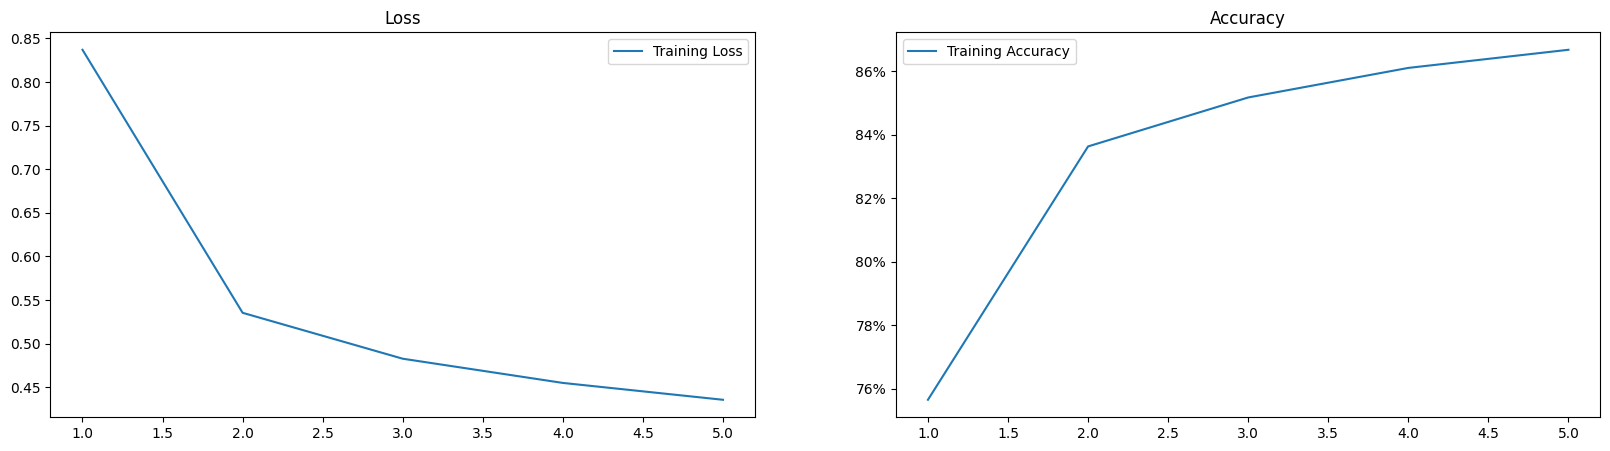

In [9]:
epochs = np.arange(5) + 1

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title('Loss')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()